# 2D Stokes Using Firedrake

Copyright (C) 2010-2020 Luke Olson<br>
Copyright (C) 2020 Andreas Kloeckner

<details>
<summary>MIT License</summary>
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in
all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
THE SOFTWARE.
</details>

-----

$$
\let\b=\boldsymbol
\def\ip#1#2{\left\langle #1, #2\right\rangle}
\begin{eqnarray*}
  \Delta \b{u}+ \nabla p & = & -\b{f} \quad (x \in \Omega),\\
  \nabla \cdot \b{u} & = & 0 \quad (x \in \Omega),\\
  \b{u} & = & \b{u}_0 \quad (x \in \partial \Omega) .
\end{eqnarray*}
$$

In [3]:
import numpy as np
import numpy.linalg as la
import firedrake.mesh as fd_mesh
import matplotlib.pyplot as plt

from firedrake import *

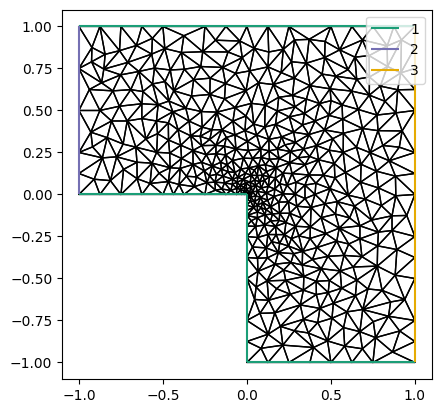

In [4]:
import meshpy.triangle as triangle

def round_trip_connect(start, end):
    return [(i, i+1) for i in range(start, end)] + [(end, start)]

reentrant_corner = 1

def make_mesh():
    if not reentrant_corner:
        # tube
        points = [
                  (-1, -1), 
                  (1,-1),
                  (1, 1),
                  (-1, 1)]
    else:
        # reentrant corner
        points = [
                  (-1, 0), 
                  (0,0), 
                  (0, -1), 
                  (1,-1),
                  (1, 1),
                  (-1, 1)]
        
    facets = round_trip_connect(0, len(points)-1)
    # 1 for "prescribed 0 velocity"
    # 2 for "prescribed velocity"
    facet_markers = [1] * len(facets)
    facet_markers[-1] = 2
    facet_markers[-3] = 3

    def needs_refinement(vertices, area):
        bary = np.sum(np.array(vertices), axis=0)/3
        if reentrant_corner:
            max_area = 0.0001 + la.norm(bary, np.inf)*0.01
        else:
            max_area = 0.01
        return bool(area > max_area)

    info = triangle.MeshInfo()
    info.set_points(points)
    info.set_facets(facets, facet_markers=facet_markers)

    built_mesh = triangle.build(info, refinement_func=needs_refinement)
    plex = fd_mesh.plex_from_cell_list(
        2, np.array(built_mesh.elements), np.array(built_mesh.points), COMM_WORLD)

    import firedrake.cython.dmcommon as dmcommon

    v_start, v_end = plex.getDepthStratum(0)   # vertices
    for facet, fmarker in zip(built_mesh.facets, built_mesh.facet_markers):
        vertices = [fvert + v_start for fvert in facet]
        join = plex.getJoin(vertices)
        plex.setLabelValue(dmcommon.FACE_SETS_LABEL, join[0], fmarker)

    return Mesh(plex)
    
mesh = make_mesh()

triplot(mesh)
plt.gca().set_aspect("equal")
plt.legend()

Choose some function spaces:

In [20]:
if 0:
    # "P1-P1"
    V = VectorFunctionSpace(mesh, "CG", 1)
    W = FunctionSpace(mesh, "CG", 1)
elif 1:
    # MINI
    P1 = FiniteElement("CG", cell=mesh.ufl_cell(), degree=1)
    B = FiniteElement("B", cell=mesh.ufl_cell(), degree=3)
    mini = P1 + B
    V = VectorFunctionSpace(mesh, mini)
    W = FunctionSpace(mesh, 'CG', 1)
else:
    # Taylor-Hood
    V = VectorFunctionSpace(mesh, "CG", 2)
    W = FunctionSpace(mesh, "CG", 1)
    
Z = V * W

Set up the weak form:
$$
\begin{align*}
  a (\b{u}, \b{v}) = \int_{\Omega} J_{\b{u}} : J_{\b{v}}, \\
  b (\b{v}, q) = \int_{\Omega} \nabla \cdot \b{v}q,
\end{align*}
$$
where $A : B = \operatorname{tr} (AB^T)$.
Find $(\b{u}, p) \in X \times M$ so that
$$
\begin{eqnarray*}
  a (\b{u}, \b{v}) + b (\b{v}, p) & = &
  \ip{\b{f}}{\b{v}}_{L^2} \quad (\b{v} \in X),\\
  b (\b{u}, q) & = & 0 \quad (q \in M),
\end{eqnarray*}
$$

In [21]:
u, p = TrialFunctions(Z)
v, q = TestFunctions(Z)

a = (inner(grad(u), grad(v)) - p * div(v) + div(u) * q)*dx

L = inner(Constant((0, 0)), v) * dx

Pick boundary conditions:

In [22]:
bcs = [
    DirichletBC(Z.sub(0), Constant((1, 0)), (2,)),
    DirichletBC(Z.sub(0), Constant((0.5 if reentrant_corner else 1, 0)), (3,)),
    DirichletBC(Z.sub(0), Constant((0, 0)), (1,))
]

Let the linear solver know about the nullspace:

In [23]:
nullspace = MixedVectorSpaceBasis(
    Z, [Z.sub(0), VectorSpaceBasis(constant=True)])

firedrake:WARNING No comm specified for VectorSpaceBasis, COMM_WORLD assumed


Solve:

In [24]:
upsol = Function(Z)
usol, psol = upsol.subfunctions

solve(a == L, upsol, bcs=bcs,
      nullspace=nullspace,
      solver_parameters={'pc_type': 'fieldsplit',
                         'ksp_rtol': 1e-15,
                         'pc_fieldsplit_type': 'schur',
                         'fieldsplit_schur_fact_type': 'diag',
                         'fieldsplit_0_pc_type': 'redundant',
                         'fieldsplit_0_redundant_pc_type': 'lu',
                         'fieldsplit_1_pc_type': 'none',
                         'ksp_monitor_true_residual': None,
                         'mat_type': 'aij'})

    Residual norms for firedrake_14_ solve.
    0 KSP preconditioned resid norm 1.346059418027e+02 true resid norm 5.120663688914e+00 ||r(i)||/||b|| 1.000000000000e+00
    1 KSP preconditioned resid norm 6.478207292457e-02 true resid norm 5.713573615240e-03 ||r(i)||/||b|| 1.115787710802e-03
    2 KSP preconditioned resid norm 7.423463661713e-07 true resid norm 5.711395787996e-03 ||r(i)||/||b|| 1.115362409049e-03
    3 KSP preconditioned resid norm 8.900078779396e-12 true resid norm 5.711395787993e-03 ||r(i)||/||b|| 1.115362409048e-03
    4 KSP preconditioned resid norm 1.340293119055e-14 true resid norm 5.711395787993e-03 ||r(i)||/||b|| 1.115362409048e-03


Plot the velocity:

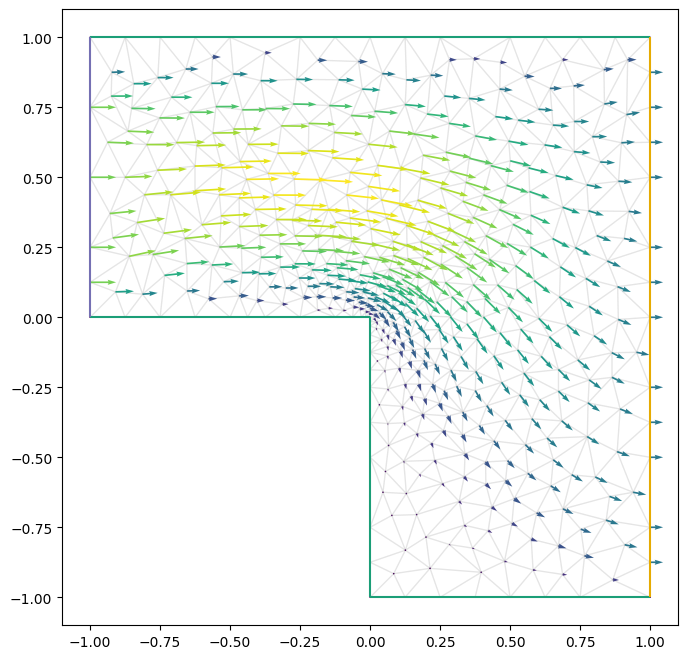

In [25]:
plt.figure(figsize=(8, 8))
ax = plt.gca()
ax.set_aspect("equal")
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
quiver(usol, axes=ax)

Plot the pressure and the divergence of $u$:


Text(0.5, 1.0, '$\\nabla\\cdot u$')

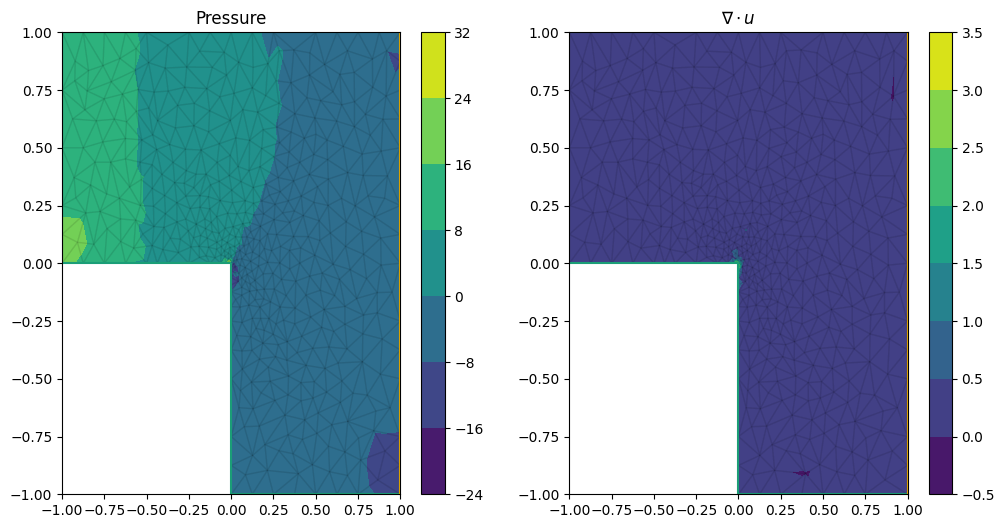

In [26]:
div_usol = project(div(usol), W)

plt.figure(figsize=(12,6))
plt.subplot(121)
ax = plt.gca()
l = tricontourf(psol, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)
plt.title("Pressure")

plt.subplot(122)
ax = plt.gca()
l = tricontourf(div_usol, axes=ax)
triplot(mesh, axes=ax, interior_kw=dict(alpha=0.05))
plt.colorbar(l)
plt.title(r"$\nabla\cdot u$")